## CPSC 533V: Assignment 2 - Tabular Q Learning

<p style="font-size: 1.2em;">Due Date: Wed Oct 6, 2021</p>
<p style="font-size: 1.2em;">100 Points Total (9% of final grade)</p>

## Important Notes

* Your deliverable is this Jupyter Notebook. Submission will be done via Canvas.
* For instructions on installing and running Jupyter Notebook: https://jupyter.org/install
    * Start by cloning this repository: git clone git@github.com:UBCMOCCA/CPSC533V_2021W1.git
    * Install Jupyter Notebook using either `conda install jupyter` or `pip install jupyter`
    * Inside the `a2` folder, run `jupyter notebook` and a webpage should open in the browser
    * If not, follow the instruction in terminal to launch an interactive session
* If you use additional Python packages, please list them  as it will help with grading. 
* **We recommend working in groups of two**. List your names and student numbers below (if you use a different name on Canvas).

<ul style="list-style-type: none; font-size: 1.2em;">
<li>Name (and student ID): Kim Dinh </li>
<li>Name (and student ID): Alan Milligan </li>
</ul>


## Debugging Tips

* Debugging in Jupyter Notebook can be using `pdb` or `ipdb`
* Insert `import ipdb; ipdb.set_trace()` to where you want to set a breakpoint
* See https://docs.python.org/3/library/pdb.html#debugger-commands for useful commands
* Remember to quit out from an `ipdb` session, otherwise you may wonder why a code cell is taking forever to complete 😉

---

##  Tabular Q-Learning

Tabular Q-learning is an RL algorithm for problems with discrete states and discrete actions. The algorithm is described in the class notes, which borrows the summary description from [Section 6.5](http://incompleteideas.net/book/RLbook2018.pdf#page=153) of Richard Sutton's RL book. In the tabular approach, the Q-value is represented as a lookup table. As discussed in class, Q-learning can further be extended to continuous states and discrete actions, leading to the [Atari DQN](https://arxiv.org/abs/1312.5602) / Deep Q-learning algorithm.  However, it is important and informative to first fully understand tabular Q-learning.

Informally, Q-learning works as follows: The goal is to learn the optimal Q-function: 
`Q(s,a)`, which is the *value* of being at state `s` and taking action `a`.  Q tells you how well you expect to do, on average, from here on out, given that you act optimally.  Once the Q function is learned, choosing an optimal action is as simple as looping over all possible actions and choosing the one with the highest Q (optimal action $a^* = \text{max}_a Q(s,a)$).  To learn Q, we initialize it arbitrarily and then iteratively refine it using the Bellman backup equation for Q functions, namely: 
$Q(s,a) \leftarrow Q(s,a) + \alpha [r + \gamma \text{max}_a Q(s', a) - Q(s,a)]$.
Here, $r$ is the reward associated with with the transition from state s to s', and $\alpha$ is a learning rate.

In this assignment you will implement tabular Q-learning and apply it to CartPole – an environment with a **continuous** state space.  To apply the tabular method, **you will need to discretize the CartPole state space** by dividing the state-space into bins.


**Assignment goals:**
- To become familiar with Python, NumPy, and OpenAI Gym
- To understand and implement tabular Q-learning
- To experiment tabular Q-learning on your implemention of discrete CartPole environment
- (Optional) To develop further intuition regarding possible variations of the algorithm

## Introduction
Deep reinforcement learning has generated impressive results for board games ([Go][go], [Chess/Shogi][chess]), video games ([Atari][atari], , [DOTA2][dota], [StarCraft II][scii]), [and][baoding] [robotic][rubix] [control][anymal] ([of][cassie] [course][mimic] 😉).  RL is beginning to work for an increasing range of tasks and capabilities.  At the same time, there are many [gaping holes][irpan] and [difficulties][amid] in applying these methods. Understanding deep RL is important if you wish to have a good grasp of the modern landscape of control methods.

These next several assignments are designed to get you started with deep reinforcement learning, to give you a more close and personal understanding of the methods, and to provide you with a good starting point from which you can branch out into topics of interest. You will implement basic versions of some of the important fundamental algorithms in this space, including Q-learning, policy gradient, and search methods.

We will only have time to cover a subset of methods and ideas in this space.
If you want to dig deeper, we suggest following the links given on the course webpage.  Additionally we draw special attention to the [Sutton book](http://incompleteideas.net/book/RLbook2018.pdf) for RL fundamentals and in depth coverage, and OpenAI's [Spinning Up resources](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html) for a concise intro to RL and deep RL concepts, as well as good comparisons and implementations of modern deep RL algorithms.


[atari]: https://arxiv.org/abs/1312.5602
[go]: https://deepmind.com/research/case-studies/alphago-the-story-so-far
[chess]:https://deepmind.com/blog/article/alphazero-shedding-new-light-grand-games-chess-shogi-and-go 
[dota]: https://openai.com/blog/openai-five/
[scii]: https://deepmind.com/blog/article/AlphaStar-Grandmaster-level-in-StarCraft-II-using-multi-agent-reinforcement-learning
[baoding]: https://bair.berkeley.edu/blog/2019/09/30/deep-dynamics/
[rubix]: https://openai.com/blog/solving-rubiks-cube/
[cassie]: https://www.cs.ubc.ca/~van/papers/2019-CORL-cassie/index.html
[mimic]: https://www.cs.ubc.ca/~van/papers/2018-TOG-deepMimic/index.html
[anymal]: https://arxiv.org/abs/1901.08652


[irpan]: https://www.alexirpan.com/2018/02/14/rl-hard.html
[amid]: http://amid.fish/reproducing-deep-rl



In [2]:
# Install dependencies
# Only run if necessary
#!pip install gym
#!pip install numpy
#!pip install matplotlib

In [1]:
import time
import itertools
import numpy as np
import gym
import copy, math

---

## 1. Explore the CartPole environment [18 pts]

Your first task is to familiarize yourself with the OpenAI gym interface and the [CartPole environment]( https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)
by writing a simple hand-coded policy to try to solve it.  
Read this brief introduction on [OpenAI Gym](https://gym.openai.com/docs/) to get started. 
The gym interface is very popular and you will see many algorithm implementations and 
custom environments that support it.  You may even want to use the API in your course projects, 
to define a custom environment for a task you want to solve.

Below is some example code that runs a simple random policy.  You are to:
- **run the code to see what it does**
- **write code that chooses an action based on the observation**.  You will need to learn about the gym API and to read the CartPole documentation to figure out what the `action` and `obs` vectors mean for this environment. 
Your hand-coded policy can be arbitrary, and it should ideally do better than the random policy.  There is no single correct answer. The goal is to become familiar with `env`s.
- **write code to print out the total reward gained by your policy in a single episode run**
- **answer the short-response questions below** (see the TODOs for all of this)

In [2]:
env = gym.make('CartPole-v1')  # you can also try LunarLander-v2, but make sure to change it back
print('observation space:', env.observation_space)
print('action space:', env.action_space)

# To find out what the observations mean, read the CartPole documentation.
# Uncomment the lines below, or visit the source file: 
# https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

#cartpole = env.unwrapped
#cartpole?

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


**1.1 [10pts] Complete the `TODO`s in the next code block**

In [4]:
# Q1.1

# Runs a single episode and render it
# Try running this before editing anything

obs = env.reset()  # get initial state/observation
total_reward = 0

while True:
    # TODO: replace this `action` with something that depends on `obs`
    action = 0 if obs[2] < 0 else 1
    obs, reward, done, info = env.step(action)
    total_reward += reward
    
    env.render()
    time.sleep(0.1)  # so it doesn't render too quickly
    if done: break
env.close()

# TODO: print out your total sum of rewards here
print("Total reward: {:.2f}".format(total_reward))

Total reward: 39.00


**1.2. [2pts] Describe the observation and action spaces of CartPole.  What does each of the values mean/do?**

*Hint: Look at the full [source code here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) if you haven't already.*


The observation space of CartPole is a subset of $\mathbb{R}^4$ and specifies the possible values of the state. The range of each dimension of observation space indicate the range of cart position, cart velocity, pole angle, pole angular velocity respectively.

The action space of CartPole is a discrete space with 2 elements: "move left" and "move right".

**1.3. [2pts] What distribution is used to sample initial states? (see the `reset` function)** 

Intial states are sampled from the uniform distribution on $[-0.05, 0.05]^4$.

**1.4. [2pts] What is the termination condition, which determines if the `env` is `done`?** 

The termination condition is that the absolute value of either cart position or pole angle exceeds the thresholds given by ```self.x_threshold``` and ```self.theta_threshold_radians``` in the source.

**1.5. [2pts] Briefly describe your policy.  What observation information does it use?  What score did you achieve (rough maximum and average)?  And how does it compare to the random policy?**

My policy is that if the pole is leaned to the left (negative pole angle) then push left, otherwise push right. After 10 simulations, the maximum and average total reward is 55 and 44.2 respectively. This is clearly better than the random policy which has average total reward 21.9 after 10 simulations.

---

## 2. Discretize the environment [32 pts]

Next, we need to discretize CartPole's continuous state space to work for tabular Q-learning.  While this is in part  a contrived usage of tabular methods, given the existence of other approaches that are designed to cope with continuous state-spaces, it is also interesting to consider whether tabular methods can be adapted more directly via discretization of the state into bins. Furthermore, tabular methods are simple, interpretabile, and can be proved to converge, and thus they still remain relevant.

Your task is to discretize the state/observation space so that it is compatible with tabular Q-learning.  To do this:
- **implement `obs_normalizer` to pass its test**
- **implement `get_bins` to pass its test**
- **then answer questions 2.3 and 2.4**

[map]: https://arxiv.org/abs/1504.04909
[qd]: https://quality-diversity.github.io/

**2.1 [15pts for passing test_normed]** Normalize observation space

In [3]:
# Q2.1

def obs_normalizer(obs):
    """Normalize the observations between 0 and 1
    
    If the observation has extremely large bounds, then clip to a reasonable range before normalizing; 
    (-2,2) should work.  (It is ok if the solution is specific to CartPole)
    
    Args:
        obs (np.ndarray): shape (4,) containing an observation from CartPole using the bound of the env
    Returns:
        normed (np.ndarray): shape (4,) where all elements are roughly uniformly mapped to the range [0, 1]
    
    """
    # HINT: check out env.observation_space.high, env.observation_space.low
    
    # TODO: implement this function
    normed = copy.deepcopy(obs)
    x_high, x_low = 4.8, -4.8
    theta_high, theta_low = 48 * math.pi / 360, -48 * math.pi / 360
    
    # clip cart velocity and pole angular velocity to [-2,2]
    normed[[1,3]] = np.clip(normed[[1,3]], -2, 2)
    # normalize
    normed[0] = (normed[0] - x_low) / (x_high - x_low)
    normed[2] = (normed[2] - theta_low) / (theta_high - theta_low)
    normed[[1,3]] = (normed[[1,3]] + 2) / 4
    
    return normed

In [4]:
### TEST 2.1
def test_normed():
    obs = env.reset()
    while True:
        obs, _, done, _ =  env.step(env.action_space.sample())
        normed = obs_normalizer(obs) 
        assert np.all(normed >= 0.0) and np.all(normed <= 1.0), '{} are outside of (0,1)'.format(normed)
        if done: break
    env.close()
    print('Passed!')
test_normed()

Passed!


**2.2 [13pts for passing test_binned]**

In [5]:
# Q2.2

def get_bins(normed, num_bins):
    """Map normalized observations (0,1) to bin index values (0,num_bins-1)
    
    Args:
        normed (np.ndarray): shape (4,) output from obs_normalizer
        num_bins (int): how many bins to use
    Returns:
        binned (np.ndarray of type np.int): shape (4,) where all elements are values in range [0,num_bins-1]
    
    """
    # TODO: implement this function
    # take minimum with num_bins - 1 so that the value 1 is in the last bin
    binned = np.minimum((normed * num_bins).astype(np.int32), num_bins - 1)
    
    return binned

In [6]:
### TEST 2.2
obs = env.reset()
env.close()

def test_binned(num_bins):
    normed = np.array([0.0, 0.2, 0.8, 1.0])
    binned = get_bins(normed, num_bins)
    assert np.all(binned >= 0) and np.all(binned < num_bins), '{} supposed to be between (0, {})'.format(binned, num_bins-1)
    assert binned.dtype == np.int32, "You should also make sure to cast your answer to int using np.int() or arr.astype(np.int)" 
    
test_binned(5)
test_binned(10)
test_binned(50)
print('Passed!')

Passed!


**2.3. [2pts] If your state has 4 values and each is binned into N possible bins, how many bins are needed to represent all unique possible states)?**



$N^4$

**2.4. [2pts] After discretizing state space, is the dynamics deterministic or non-deterministic? Explain your answer in one to two sentences.**

The discretization causes the dynamics to become stochastic. This is because we lose information when we go from continuous values to bins, so this problems turned from an MDP to a POMDP.

---

## 3. Solve the env [30 pts] 

Using the pseudocode below and the functions you implemented above, implement tabular Q-learning and use it to solve CartPole.

We provide setup code to initialize the Q-table and give examples of interfacing with it. Write the inner and outer loops to train your algorithm.  These training loops will be similar to those deep RL approaches, so get used to writing them!

The algorithm (excerpted from Section 6.5 of [Sutton's book](http://incompleteideas.net/book/RLbook2018.pdf)) is given below:

![Sutton RL](https://i.imgur.com/mdcWVRL.png)

in summary:
- **implement Q-learning using this pseudocode and the helper code**
- **answer the questions below**
- **run the suggested experiments and otherwise experiment with whatever interests you**

In [15]:
# setup (see last few lines for how to use the Q-table)

# hyper parameters. feel free to change these as desired and experiment with different values
num_bins = 10
alpha = 0.1
gamma = 0.99
log_n = 1000
# epsilon greedy
eps = 0.05  #usage: action = optimal if np.random.rand() > eps else random

obs = env.reset()

# Q-table initialized to zeros.  first 4 dims are state, last dim is for action (0,1) for left,right.
Q = np.zeros([num_bins]*len(obs)+[env.action_space.n])

# helper function to convert observation into a binned state so we can index into our Q-table
obs2bin = lambda obs: tuple(get_bins(obs_normalizer(obs), num_bins=num_bins))

s = obs2bin(obs)

print('Shape of Q Table: ', Q.shape) # you can imagine why tabular learning does not scale very well
print('Original obs {} --> binned {}'.format(obs, s))
print('Value of Q Table at that obs/state value', Q[s])

Shape of Q Table:  (10, 10, 10, 10, 2)
Original obs [ 0.01712155  0.01500509 -0.00751451  0.0068919 ] --> binned (5, 5, 4, 5)
Value of Q Table at that obs/state value [0. 0.]
(2,)


**3.1 [25pts] Implement Q-learning**

In [8]:
# Q3.1

# TODO: implement Q learning, following the pseudo-code above. 
#     - you can follow it almost exactly, but translating things for the gym api and our code used above
#     - make sure to use e-greedy, where e = random about 0.05 percent of the time
#     - make sure to do the S <-- S' step because it can be easy to forget
#     - every log_n steps, you should render your environment and
#       print out the average total episode rewards of the past log_n runs to monitor how your agent trains
#      (your implementation should be able to break at least +150 average reward value, and you can use that 
#       as a breaking condition.  It make take several minutes to run depending on your computer.)

# if average_reward_goal is None then train with exactly num_episodes episodes
# otherwise train until either average reward over the log_n episodes exceed average_reward_goal
def CartPole_Q_learning(num_episodes=20000, num_bins=10, alpha=0.1, gamma=0.99, 
                        log_n=1000, eps=0.05, average_reward_goal=150):
    # Q-table initialized to zeros.
    Q = np.zeros([num_bins]*len(env.reset())+[env.action_space.n])
    
    # episode_rewards stores the total rewards of each episode
    episode_rewards = []
    
    for episode in range(num_episodes):   
        S = obs2bin(env.reset())
        episode_rewards.append(0)     
        while True:            
            # choose action by epsilon-greedy policy
            A = np.argmax(Q[S]) if np.random.rand() > eps else np.random.choice(2)
            
            # take action, update Q and S
            obs, R, done, _ = env.step(A)
            S_next = obs2bin(obs)
            Q[S][A] = Q[S][A] + alpha * (R + gamma * np.max(Q[S_next]) - Q[S][A])
            S = S_next
            episode_rewards[episode] += R
            '''
            # render after every log_n episodes
            if (episode + 1) % log_n == 0: 
                env.render()
                time.sleep(0.01)
            '''
            if done: break
        
        # print out average total episode rewards after every log_n episodes
        if (episode + 1) % log_n == 0:
            average_reward = np.mean(episode_rewards[-log_n:])
            print("Average rewards of the past {} episodes at iteration {}: {:.2f}".format(log_n, episode+1, average_reward))
            if (average_reward_goal is not None) and (average_reward > average_reward_goal): break

    if (average_reward_goal is not None) and (np.mean(episode_rewards[-log_n:]) <= average_reward_goal):
        print("WARNING: Average reward did not exceed average_reward_goal")

    return Q, episode_rewards

In [39]:
_, _ = CartPole_Q_learning()

Average rewards of the past 1000 episodes at iteration 1000: 10.98
Average rewards of the past 1000 episodes at iteration 2000: 10.91
Average rewards of the past 1000 episodes at iteration 3000: 11.19
Average rewards of the past 1000 episodes at iteration 4000: 10.68
Average rewards of the past 1000 episodes at iteration 5000: 10.82
Average rewards of the past 1000 episodes at iteration 6000: 28.96
Average rewards of the past 1000 episodes at iteration 7000: 71.94
Average rewards of the past 1000 episodes at iteration 8000: 133.59
Average rewards of the past 1000 episodes at iteration 9000: 214.16


**3.2 [5pts] Plot the learning curve**

Average rewards of the past 1000 episodes at iteration 1000: 10.47
Average rewards of the past 1000 episodes at iteration 2000: 10.59
Average rewards of the past 1000 episodes at iteration 3000: 10.55
Average rewards of the past 1000 episodes at iteration 4000: 10.98
Average rewards of the past 1000 episodes at iteration 5000: 19.59
Average rewards of the past 1000 episodes at iteration 6000: 71.21
Average rewards of the past 1000 episodes at iteration 7000: 177.68
Average rewards of the past 1000 episodes at iteration 8000: 230.92
Average rewards of the past 1000 episodes at iteration 9000: 287.71
Average rewards of the past 1000 episodes at iteration 10000: 249.22
Average rewards of the past 1000 episodes at iteration 1000: 9.69
Average rewards of the past 1000 episodes at iteration 2000: 9.88
Average rewards of the past 1000 episodes at iteration 3000: 9.81
Average rewards of the past 1000 episodes at iteration 4000: 9.83
Average rewards of the past 1000 episodes at iteration 5000: 

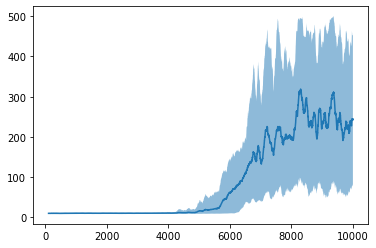

In [15]:
# Q3.2

# TODO: Plot the learning curve.
#       Below is a snippet for generate a curve with upper and lower bounds.
#       From your training loop above, save the episode rewards.
#       Rerun the training code a few times to get min and max.


import matplotlib.pyplot as plt
from bottleneck import move_mean

num_episodes = 10000

# lists of min and max episode rewards
min_episode_rewards = np.full(num_episodes, np.inf)
max_episode_rewards = np.full(num_episodes, 0)
mean_episode_rewards = np.full(num_episodes, 0)

plt.close()
for i in range(5):
    # To make the plotting easier, set average_reward_goal to None and run with same num_episodes
    # (see Cartpole_Q_learning implementation above)
    _, episode_rewards = CartPole_Q_learning(num_episodes=num_episodes, average_reward_goal=None)

    min_episode_rewards = np.minimum(min_episode_rewards, episode_rewards)
    max_episode_rewards = np.maximum(max_episode_rewards, episode_rewards)
    mean_episode_rewards = mean_episode_rewards + np.array(episode_rewards)/5

    #plt.plot(episode_rewards)

window_size = 100
plt.plot(move_mean(mean_episode_rewards, window_size))
plt.fill_between(np.arange(num_episodes),
                move_mean(min_episode_rewards, window_size),
                move_mean(max_episode_rewards, window_size),
                alpha=0.5)

## 4. Experiments [20 pts]

Given a working algorithm, you will run a few experiments.  Either make a copy of your code above to modify, or make the modifications in a way that they can be commented out or switched between (with boolean flag if statements).

**4.2. [10pts] $\epsilon$-greedy.**  How sensitive are the results to the value of $\epsilon$?   First, write down your prediction of what would happen if $\epsilon$ is set to various values, including for example [0, 0.05, 0.25, 0.5].

At $\epsilon = 0$, we will never learn as there are no explore actions taken, and since we initlized to 0 we are just going to go left and die each time. For 0.05, this is what we did above so I "predict" that it starts off somewhat low but tranins relativly quickly. For 0.25, I suspect the peak performance will be somewhat worse than 0.05, but the rate at which it gets there to be much faster due to better explore near the start. For 0.5, I suspect peak performance will be pretty bad given no matter how good of a policy you learn, you will be taking random actions half the time and so there is a pretty good chance you'll do an unlucky sequence and die.

Now run the experiment and observe the impact on the algorithm.  Report the results below.

In [43]:
_, _ = CartPole_Q_learning(eps=0)

Average rewards of the past 1000 episodes at iteration 1000: 9.32
Average rewards of the past 1000 episodes at iteration 2000: 9.35
Average rewards of the past 1000 episodes at iteration 3000: 9.36
Average rewards of the past 1000 episodes at iteration 4000: 9.34
Average rewards of the past 1000 episodes at iteration 5000: 9.34
Average rewards of the past 1000 episodes at iteration 6000: 9.32
Average rewards of the past 1000 episodes at iteration 7000: 9.37
Average rewards of the past 1000 episodes at iteration 8000: 9.38
Average rewards of the past 1000 episodes at iteration 9000: 9.35
Average rewards of the past 1000 episodes at iteration 10000: 9.34
Average rewards of the past 1000 episodes at iteration 11000: 9.32
Average rewards of the past 1000 episodes at iteration 12000: 9.32
Average rewards of the past 1000 episodes at iteration 13000: 9.32
Average rewards of the past 1000 episodes at iteration 14000: 9.34
Average rewards of the past 1000 episodes at iteration 15000: 9.33
Aver

In [44]:
_, _ = CartPole_Q_learning(eps=0.05)

Average rewards of the past 1000 episodes at iteration 1000: 9.74
Average rewards of the past 1000 episodes at iteration 2000: 9.84
Average rewards of the past 1000 episodes at iteration 3000: 9.96
Average rewards of the past 1000 episodes at iteration 4000: 9.89
Average rewards of the past 1000 episodes at iteration 5000: 16.43
Average rewards of the past 1000 episodes at iteration 6000: 89.72
Average rewards of the past 1000 episodes at iteration 7000: 175.26


In [45]:
_, _ = CartPole_Q_learning(eps=0.25)

Average rewards of the past 1000 episodes at iteration 1000: 43.15
Average rewards of the past 1000 episodes at iteration 2000: 128.95
Average rewards of the past 1000 episodes at iteration 3000: 167.55


In [47]:
_, _ = CartPole_Q_learning(eps=0.5)

Average rewards of the past 1000 episodes at iteration 1000: 41.18
Average rewards of the past 1000 episodes at iteration 2000: 80.14
Average rewards of the past 1000 episodes at iteration 3000: 88.22
Average rewards of the past 1000 episodes at iteration 4000: 88.66
Average rewards of the past 1000 episodes at iteration 5000: 94.90
Average rewards of the past 1000 episodes at iteration 6000: 97.61
Average rewards of the past 1000 episodes at iteration 7000: 97.22
Average rewards of the past 1000 episodes at iteration 8000: 97.88
Average rewards of the past 1000 episodes at iteration 9000: 96.62
Average rewards of the past 1000 episodes at iteration 10000: 94.86
Average rewards of the past 1000 episodes at iteration 11000: 97.71
Average rewards of the past 1000 episodes at iteration 12000: 91.30
Average rewards of the past 1000 episodes at iteration 13000: 84.72
Average rewards of the past 1000 episodes at iteration 14000: 97.37
Average rewards of the past 1000 episodes at iteration 15

For $\epsilon=0$, we in fact never learn and the average reward is stuck at about 9.3. 

When we used $\epsilon=0.25$, the average rewards were much higher for the first few thousand episodes and exceeded 150 faster than when we used $\epsilon=0.05$. This is because $\epsilon=0.25$ allowed more exploration at the start, hence found the optimal policy more quickly.

For $\epsilon=0.5$, the average rewards increased quickly for the first few thousand episodes due to exploration. But it seems that the average rewards could not exceed 100 because it took random actions too often and terminated more easily.

**4.3. [10pts] Design your own experiment.** Design a modification that you think would either increase or reduce performance.  A simple example (which you can use) is initializing the Q-table differently, and thinking about how this might alter performance. Write down your idea, what you think might happen, and why.

I personally think an adaptive $\epsilon$ would be better, that is explore lots at the start and less later so I implimented that. In this problem, I also felt initilizing Q to random binary values would be more effective than 0 as going back and forth randomly is going to be a better policy for pole balancing than running left every time you don't know what to do. Finally, I changed this to double Q learning since we have stochastic dynamics and would like to avoid maximization bias. Here is the implementation.

Run the experiment and report the results.

In [63]:
eps = 1
eps_decay = 0.999
Q1 = np.random.randint(2,size=[num_bins]*len(obs)+[env.action_space.n]).astype('float32')
Q2 = np.random.randint(2,size=[num_bins]*len(obs)+[env.action_space.n]).astype('float32')
total_rewards = 0
episode = 0

# Outer Loop over episodes
while True:
    S = obs2bin(env.reset())
    while True:            
        A = np.argmax(Q1[S] + Q2[S]) if np.random.rand() > eps else np.random.choice([0,1])
        S_prime, R, done, info = env.step(A)
        S_prime = obs2bin(S_prime)

        if np.random.rand() > 0.5:
            Q1[S][A] = Q1[S][A] + alpha*(R + gamma*np.max(Q2[S_prime][np.argmax(Q1[S_prime])]) - Q1[S][A])
        else:
            Q2[S][A] = Q2[S][A] + alpha*(R + gamma*np.max(Q1[S_prime][np.argmax(Q2[S_prime])]) - Q2[S][A])
        
        total_rewards += R
        S = S_prime

        if done: break 

    if (episode + 1) % log_n == 0:
        print("Average rewards of the past {} episodes at iteration {}: {:.2f}".format(log_n, episode+1, total_rewards/log_n))
        if total_rewards/log_n > 150: break
        total_rewards = 0

    if eps > 0.05:
        eps *= eps_decay
    episode += 1

Average rewards of the past 1000 episodes at iteration 1000: 33.62
Average rewards of the past 1000 episodes at iteration 2000: 122.29
Average rewards of the past 1000 episodes at iteration 3000: 240.47


This approach seemed quite effective, reaching the threshold in 3000-4000 episodes most of the times, which based on what I've seen was superior to the vanilla implementation. However, at times it can be as worse as the worst behaviour seen with the previous implementation. As for which change was actually most effective we would have to do some ablations, but I would guess the initilization would change the most.

---

## A. Extensions (optional)

- does the learning rate make a difference?
- visualize the Q-table to see which values are being updated and not
- design a better binning strategy that uses fewer bins for a better-performing policy
- extend this approach to work on different environments (e.g., LunarLander-v2)
- extend this approach to work on environments with continuous actions, by using a fixed set of discrete samples of the action space.  e.g., for Pendulum-v0
- implement a simple deep learning version of this.  we will see next homework that DQN uses some tricks to make the neural network training more stable.  Experiment directly with simply replacing the Q-table with a Q-Network and train the Q-Network using gradient descent with `loss = (targets - Q(s,a))**2`, where `targets = stop_grad(R + gamma * maxa(Q(s,a))`).